<a href="https://colab.research.google.com/github/parulnith/Demo1/blob/master/Residual_Analysis_for_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8: Debugging XGBoost

### Residual Analysis for XGBoost

We’ll
begin with something traditional, plotting residuals by each level of an important
input feature. We’ll be on the lookout for the rows that cause the largest mistakes and
any strong patterns in our residual plots. Then we’ll break our predictions down into
segments and analyze performance across those segments. It’s not enough to understand
how a model performs on average for high-risk use cases. We need to know
how our model performs across important segments in our data. To finish off residual
analysis, we’ll try to model our residuals with a decision tree. From that tree we’ll
learn rules about how our model makes mistakes, and we can try to use those rules to
make fewer mistakes.

## 1. Setting the Environment

Download the [zipped **data_and_package** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`. 

In [1]:
# Upload the downloaded zipped file from your system to the colab environment. 
from google.colab import files
uploaded = files.upload()

Saving Data.zip to Data.zip


In [2]:
!unzip -q "/content/Data.zip" 
%cd /content/Data

/content/Data


In [6]:
# Installing the libraries
%pip install h2o
%pip install shap
%pip install 'XGBoost==1.6'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Global hyperpameters

In [8]:
SEED = 12345 # global random seed for better reproducibility

### Imports and inits

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np                   # array, vector, matrix calculations
import os                            # file-handling
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)
import subprocess                    # manage external processes

import h2o                                                        # import h2o python bindings to java server
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.estimators.glm import H2OGeneralizedLinearEstimator      # for benchmark model
from h2o.grid.grid_search import H2OGridSearch                    # for benchmark model

# plotting ###########
import matplotlib.pyplot as plt                                   # general plotting
from matplotlib.lines import Line2D                               # necessary for custom legends
import seaborn as sns                                             # facet grid for residuals
from mpl_toolkits import mplot3d                                  # 3-D scatterplots
import matplotlib; matplotlib.rcParams.update({'font.size': 40})  # set legible font size


# enables display of plots in notebook
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

pd.options.display.max_columns = 999 # enable display of all dataframe columns in notebook

np.random.seed(SEED)                 # set random seed for reproducibility
h2o.init()                           # start h2o java server

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2i18saek
  JVM stdout: /tmp/tmp2i18saek/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2i18saek/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,"21 days, 13 hours and 31 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_23fis2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## 2. Import, Explore and Prepare the data

### Import data and clean

In [11]:
path = '../Data/Data/credit_line_increase.csv'
data = pd.read_csv(path) 
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Assign modeling roles

In [12]:
# assign target and inputs for GBM
y = 'DELINQ_NEXT'
X = [name for name in data.columns if name not in [y, 'ID', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']]
print('y =', y)
print('X =', X)

y = DELINQ_NEXT
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Split data into training and test sets for early stopping

In [13]:
np.random.seed(SEED)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()

del data

print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 19919/5045/5036


## 3. Train XGBoost GBM classifier

In [14]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dvalid = xgb.DMatrix(valid[X], valid[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
  "booster": "gbtree",
  "colsample_bytree": 0.7,
  "eta": 0.05,
  "max_depth": 5,
  "objective": "binary:logistic",
  "reg_alpha": 0.0005,
  "reg_lambda": 0.0005,
  "seed": 12345,
  "subsample": 0.5,
  "nthread": 16,
  "base_score": 0.22029218334253728,
  "monotone_constraints": {
    "LIMIT_BAL": -1,
    "PAY_0": 1,
    "PAY_2": 1,
    "PAY_3": 1,
    "PAY_4": 1,
    "PAY_5": 1,
    "PAY_6": 1,
    "BILL_AMT1": -1,
    "BILL_AMT2": -1,
    "BILL_AMT3": -1,
    "BILL_AMT4": -1,
    "BILL_AMT5": -1,
    "BILL_AMT6": -1,
    "PAY_AMT1": -1,
    "PAY_AMT2": -1,
    "PAY_AMT3": -1,
    "PAY_AMT4": -1,
    "PAY_AMT5": -1,
    "PAY_AMT6": -1
  },
  "eval_metric": "auc",
  "seed": SEED  
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # train up to 5000 iterations
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 rounds of no increase in AUC in test set 
                      verbose_eval=True)        # display iteration progress

print('\nBest training AUC: %.6f at iteration: %i.' % (xgb_model.best_score, xgb_model.best_iteration))

[0]	train-auc:0.70324	eval-auc:0.70267
[1]	train-auc:0.77079	eval-auc:0.76721
[2]	train-auc:0.77224	eval-auc:0.76663
[3]	train-auc:0.76977	eval-auc:0.76489
[4]	train-auc:0.76781	eval-auc:0.76245
[5]	train-auc:0.77274	eval-auc:0.76895
[6]	train-auc:0.77504	eval-auc:0.77176
[7]	train-auc:0.77520	eval-auc:0.77286
[8]	train-auc:0.77523	eval-auc:0.77270
[9]	train-auc:0.77526	eval-auc:0.77284
[10]	train-auc:0.77559	eval-auc:0.77330
[11]	train-auc:0.77596	eval-auc:0.77335
[12]	train-auc:0.77676	eval-auc:0.77345
[13]	train-auc:0.77664	eval-auc:0.77352
[14]	train-auc:0.77660	eval-auc:0.77373
[15]	train-auc:0.77667	eval-auc:0.77367
[16]	train-auc:0.77707	eval-auc:0.77363
[17]	train-auc:0.77734	eval-auc:0.77354
[18]	train-auc:0.77724	eval-auc:0.77335
[19]	train-auc:0.77744	eval-auc:0.77379
[20]	train-auc:0.77742	eval-auc:0.77416
[21]	train-auc:0.77741	eval-auc:0.77447
[22]	train-auc:0.77753	eval-auc:0.77453
[23]	train-auc:0.77748	eval-auc:0.77458
[24]	train-auc:0.77776	eval-auc:0.77466
[25]	train

### SHAP Feature importance

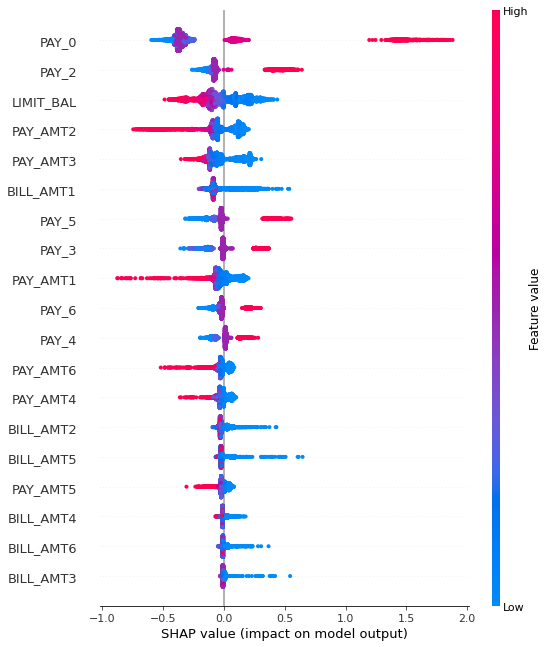

In [15]:
shap_values = xgb_model.predict(dvalid, pred_contribs=True, iteration_range=(0, xgb_model.best_iteration))
shap.summary_plot(shap_values[:, :-1], valid[xgb_model.feature_names])

## 4. Conduct Residual Analysis to Debug Model

#### Prelims to select cutoff

In [17]:
# shortcut name
yhat = 'p_DEFAULT_NEXT_MONTH' 

# copy test data and reset index
valid_yhat = valid.copy(deep=True)
valid_yhat.reset_index(drop=True, inplace=True) # Pandas joins are weird otherwise
valid_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(valid[X]), iteration_range=(0, xgb_model.best_iteration))) 

#### Helper function for PR-AUC 

In [18]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y 
        and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values.
        
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y)          # column for predicted decisions
    eps = 1e-20                    # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame = prroc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prroc_frame

# calculate and display recall and precision
prauc_frame = get_prauc(valid_yhat, y, yhat)
prauc_frame.style.set_caption('Recall and Precision')

,cutoff,recall,precision,f1
0,0.000000,1.000000,0.228147,0.371530
1,0.010000,0.998262,0.228429,0.371785
2,0.020000,0.996525,0.229814,0.373494
3,0.030000,0.995656,0.232031,0.376355
4,0.040000,0.989574,0.233929,0.378405
5,0.050000,0.986099,0.237597,0.382928
6,0.060000,0.976542,0.241876,0.387720
7,0.070000,0.961772,0.248373,0.394793
8,0.080000,0.948740,0.258768,0.406628
9,0.090000,0.914857,0.280277,0.429095


#### Best cutoff based on F1 

In [19]:
prauc_frame = prauc_frame.astype(float, errors = "raise")
gbm_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # value associated w/ index of max. F1
print('Best F1 threshold: %.2f' % gbm_cut)

Best F1 threshold: 0.30


#### Plot P-R curve

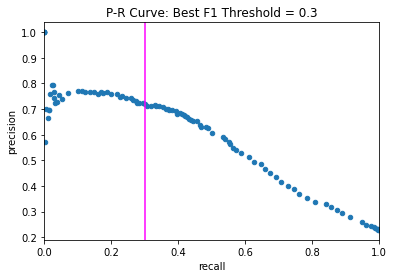

In [20]:
title_ = 'P-R Curve: Best F1 Threshold = ' + str(gbm_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(gbm_cut, color='magenta')

#### Helper function for confusion matrices

In [21]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, 
        can be sliced by a variable and level.
 
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, 
            default None.
        level: Value of by variable to slice frame before creating confusion 
               matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & 
                                        (frame_[dname] == lev_j)].shape[0]
            # i,j vs. j,i - nasty little bug updated 8/30/19
    
    return cm_frame
    
cm = get_confusion_matrix(valid_yhat, y, yhat, cutoff=gbm_cut)
cm.style.set_caption('Confusion Matrix')

,actual: 1,actual: 0
predicted: 1,635,476
predicted: 0,516,3418


#### Score test data and calculate logloss residuals

In [22]:
# shortcut name
resid = 'r_DEFAULT_NEXT_MONTH' 

# calculate logloss residuals
valid_yhat[resid] = -valid_yhat[y]*np.log(valid_yhat[yhat]) -\
                       (1 - valid_yhat[y])*np.log(1 - valid_yhat[yhat])   
    
# check that logloss is calculated correctly
# should match eval-logloss above
print('Mean logloss residual: %.6f' % valid_yhat[resid].mean())

Mean logloss residual: 0.435776


#### Plot global logloss residuals

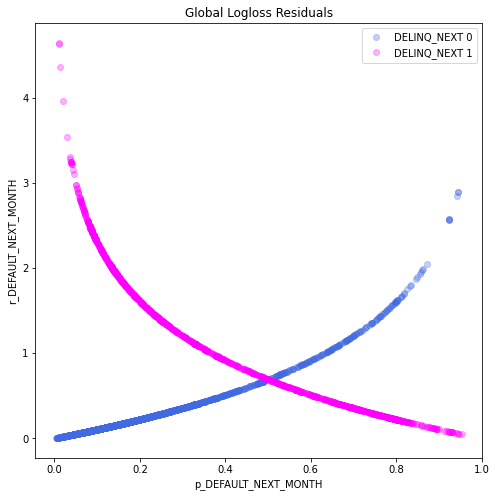

In [23]:
 # initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = valid_yhat.groupby(y) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, 
             label=' '.join([y, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1
    
# annotate plot
_ = plt.xlabel(yhat)
_ = plt.ylabel(resid)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

 #### Examine high logloss individuals

In [24]:
# sort by residual and display
valid_yhat_sorted = valid_yhat.\
    sort_values(by=resid, ascending=False).\
    reset_index(drop=True)
    
valid_yhat_sorted.head() # large positive residuals

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,11571,200000,1,2.0,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.009591,4.646968
1,6933,500000,1,1.0,1,2,37,-1,-1,-1,-1,-1,-1,4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.009753,4.630161
2,16209,360000,2,4.0,1,1,35,-2,-1,0,-1,-1,-1,94657,34529,106276,73331,7759,31840,45000,100000,73427,7759,31840,12577,1,0.012816,4.357098
3,2561,310000,2,3.0,1,2,32,-2,-2,-2,-2,-2,-2,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.018947,3.966121
4,14554,450000,1,1.0,2,2,30,0,0,0,0,0,0,610723,555086,497132,514249,462666,472480,20200,18000,25135,432130,17000,20000,1,0.029165,3.534770


#### Residuals by `PAY_0`

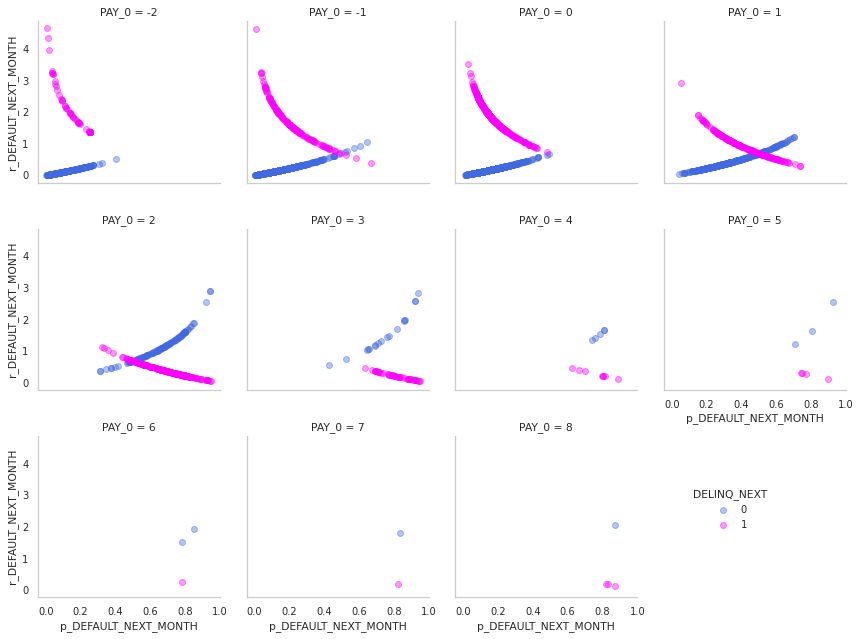

In [25]:
# some seaborn configs
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))      # consistent colors

# facet grid of residuals by PAY_0 
sorted_ =valid_yhat.sort_values(by='PAY_0')                     # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='PAY_0', hue=y, col_wrap=4)      # init grid
_ = g.map(plt.scatter, yhat, resid, alpha=0.4)                  # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

## 6. Segmented Error Analysis

#### `dict` with many classifer performance metrics

In [26]:
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Small utility functions to plot performance metrics by `PAY_0`

In [27]:
# small utility functions
# all tightly coupled to global names and data structures !!

def cm_exp_parser(expression):
    
    """ Translates abbreviated metric expressions from metric_dict 
        into executable Python statements.
    
    Arg: 
        expression: Error metric expression from metric_dict.
        
    Returns:
        Python statements based on predefined metrics in metric_dict.
        
    """
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', '(cm_dict[level].iat[0, 0] + eps)')\
                           .replace('fp', '(cm_dict[level].iat[0, 1] + eps)')\
                           .replace('fn', '(cm_dict[level].iat[1, 0] + eps)')\
                           .replace('tn', '(cm_dict[level].iat[1, 1] + eps)')

    return expression

################################################################################

def get_cm_dict(name, cutoff):

    """ Loops through levels of named variable and calculates confusion 
        matrices per level; uses dynamically generated entities to reduce 
        code duplication. 
    
    Args:
        name: Name of variable for which to calculate confusion matrices.
        cutoff: Cutoff threshold for confusion matrices. 
    
    Returns:
        Dictionary of confusion matrices. 
    
    """

    levels = sorted(list(valid_yhat[name].unique())) # get levels
    cm_dict = {} # init dict to store confusion matrices per level
    for level in levels: 
    
        # dynamically name confusion matrices by level
        # coerce to proper python names
        cm_name = '_' + str(level).replace('-', 'm') + '_cm' 
    
        # dynamically calculate confusion matrices by level
        code = cm_name + ''' = get_confusion_matrix(valid_yhat,                              
                          y, 
                          yhat, 
                          by=name, 
                          level=level, 
                          cutoff=cutoff)'''
        exec(code)
        exec('cm_dict[level] = ' + cm_name) # store in dict
        
    return cm_dict

################################################################################

def get_metrics_frame(name): 

    """ Loops through levels of named variable and metrics to calculate each 
        error metric per each level of the variable; uses dynamically generated 
        entities to reduce code duplication.
    
    Arg:
        name: Name of variable for which to calculate error metrics.
    
    Return:
        Pandas DataFrame of error metrics.
        
    """
    
    levels = sorted(list(valid_yhat[name].unique())) # get levels
    metrics_frame = pd.DataFrame(index=levels) # init Pandas frame for metrics
    eps = 1e-20 # for safe numerical operations

    # nested loop through:
    # - levels
    # - metrics 
    for level in levels:
        for metric in metric_dict.keys():
              
            # parse metric expressions into executable pandas statements
            expression = cm_exp_parser(metric_dict[metric])
        
            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)  

    # display results
    return metrics_frame

#### Plot all performance metrics across all levels of `PAY_0`

In [28]:
name = 'PAY_0'
cm_dict = get_cm_dict(name, gbm_cut) # get dict of confusion matrices

# print formatted error metrics frame: precision, title, colors
PAY_0_metrics = get_metrics_frame(name)
PAY_0_metrics['PAY_0'] = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]
PAY_0_metrics.set_index('PAY_0', inplace=True)
PAY_0_metrics.round(3).\
    style.set_caption('Error Metrics for ' + name).\
    background_gradient(cmap=sns.diverging_palette(-20, 260, n=7, as_cmap=True), 
                        axis=1)

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
PAY_0,,,,,,,,,,
-2,0.118000,0.876000,0.000000,0.000000,0.993000,0.881000,0.007000,1.000000,1.000000,0.119000
-1,0.177000,0.812000,0.212000,0.438000,0.941000,0.847000,0.059000,0.562000,0.788000,0.153000
0,0.129000,0.867000,0.089000,0.418000,0.982000,0.880000,0.018000,0.582000,0.911000,0.120000
1,0.337000,0.566000,0.799000,0.424000,0.448000,0.814000,0.552000,0.576000,0.201000,0.186000
2,0.734000,0.734000,1.000000,0.734000,0.000000,0.500000,1.000000,0.266000,0.000000,0.500000
3,0.719000,0.719000,1.000000,0.719000,0.000000,0.500000,1.000000,0.281000,0.000000,0.500000
4,0.615000,0.615000,1.000000,0.615000,0.000000,0.500000,1.000000,0.385000,0.000000,0.500000
5,0.571000,0.571000,1.000000,0.571000,0.000000,0.500000,1.000000,0.429000,0.000000,0.500000
6,0.333000,0.333000,1.000000,0.333000,0.000000,0.500000,1.000000,0.667000,0.000000,0.500000


## 7. Modeling Residuals

#### Utility functions to plot decisions tree models of residuals

In [29]:
# small utility functions
# all tightly coupled to global names and data structures !!

def train_cv_dt(model_id, frame):
                             
    """ Utility function to train decision trees.
    
    Args:
        model_id: h2o model identifier. 
        frame: Pandas DataFrame containing X and yhat on which to train 
               the decision trees.
               
    Returns:
        Path to saved model MOJO (Java scoring artifact), 
        model as h2o model object.
    
    """
        
    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                    sample_rate=1,     # use all rows in that tree
                                    mtries=-2,         # use all columns in that tree's split search
                                    max_depth=4,       # shallow trees are easier to understand
                                    seed=SEED,         # set random seed for reproducibility
                                    nfolds=3,          # cross-validation for stability and ...
                                                       # only way to get metrics for 1 tree in h2o
                                    model_id=model_id) # gives MOJO artifact a recognizable name

    # train single tree model
    tree.train(x=X, y=resid, training_frame=h2o.H2OFrame(frame))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)
    
    return mojo_path, tree

################################################################################

# 
def get_gv(title, model_id, mojo_path):

    """ Utility function to generate graphviz dot file from h2o MOJO using 
        a subprocess.
    
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier. 
        mojo_path: Path to saved model MOJO (Java scoring artifact); 
                   generated by train_cv_dt function above. 
                   
    """
    
    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of 
    # tree, see for more information: 
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]
    
    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

################################################################################

def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    
    Arg:
        model_id: h2o model identifier. 
    
    """
    
    gv_file_name = model_id + '.gv'
    
    # construct call to generate PNG from 
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call 
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)    
    _ = subprocess.call(png_args)
    

#### Fit decision trees to positive and negative residuals 

In [30]:
# train trees
mojo_path0, tree0 = train_cv_dt('tree0', valid_yhat[valid_yhat[y] == 0])                                     
mojo_path1, tree1 = train_cv_dt('tree1', valid_yhat[valid_yhat[y] == 1])  

# shutdown h2o
h2o.cluster().shutdown()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Generated MOJO path:
 /content/Data/tree0.zip
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Generated MOJO path:
 /content/Data/tree1.zip
H2O session _sid_8ca1 closed.


#### Performance metrics for trees 

In [31]:
# cv metrics for y = 0 tree
tree0.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.060973,0.000890,0.061585,0.059952,0.061382
1,mean_residual_deviance,0.008974,0.000525,0.009458,0.009049,0.008416
2,mse,0.008974,0.000525,0.009458,0.009049,0.008416
3,r2,0.871690,0.018867,0.890685,0.852953,0.871430
4,residual_deviance,0.008974,0.000525,0.009458,0.009049,0.008416
5,rmse,0.094705,0.002781,0.097251,0.095127,0.091738
6,rmsle,0.065783,0.001401,0.064318,0.067109,0.065922


In [ ]:
# cv metrics for y = 1 tree
tree1.cross_validation_metrics_summary().as_data_frame()

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.202112,0.022001,0.218936,0.177215,0.210185
1,mean_residual_deviance,0.102886,0.019640,0.120719,0.081836,0.106104
2,mse,0.102886,0.019640,0.120719,0.081836,0.106104
3,r2,0.843854,0.021967,0.825817,0.868318,0.837426
4,residual_deviance,0.102886,0.019640,0.120719,0.081836,0.106104
5,rmse,0.319751,0.031123,0.347447,0.286070,0.325736
6,rmsle,0.120124,0.004886,0.123732,0.114564,0.122077


#### Create graphviz `.dot` files for visualizing decision trees

In [32]:
get_gv('LogLoss Residual Tree (' + y + '=0)', 'tree0', mojo_path0) # .dot for y=0 tree
get_gv('LogLoss Residual Tree (' + y + '=1)', 'tree1', mojo_path1) # .dot for y=1 tree

Discovered H2O jar path:
 /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /content/Data/tree0.zip -o tree0.gv --title LogLoss Residual Tree (DELINQ_NEXT=0)
Discovered H2O jar path:
 /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /content/Data/tree1.zip -o tree1.gv --title LogLoss Residual Tree (DELINQ_NEXT=1)


#### Convert `.dot` files into `.pngs`

In [33]:
get_png('tree0') # .png for y=0 tree
get_png('tree1') # .png for y=1 tree

Calling external process ...
dot -Tpng tree0.gv -o tree0.png
Calling external process ...
dot -Tpng tree1.gv -o tree1.png


#### Decision tree for `DEFAULT_NEXT_MONTH = 0` logloss residuals

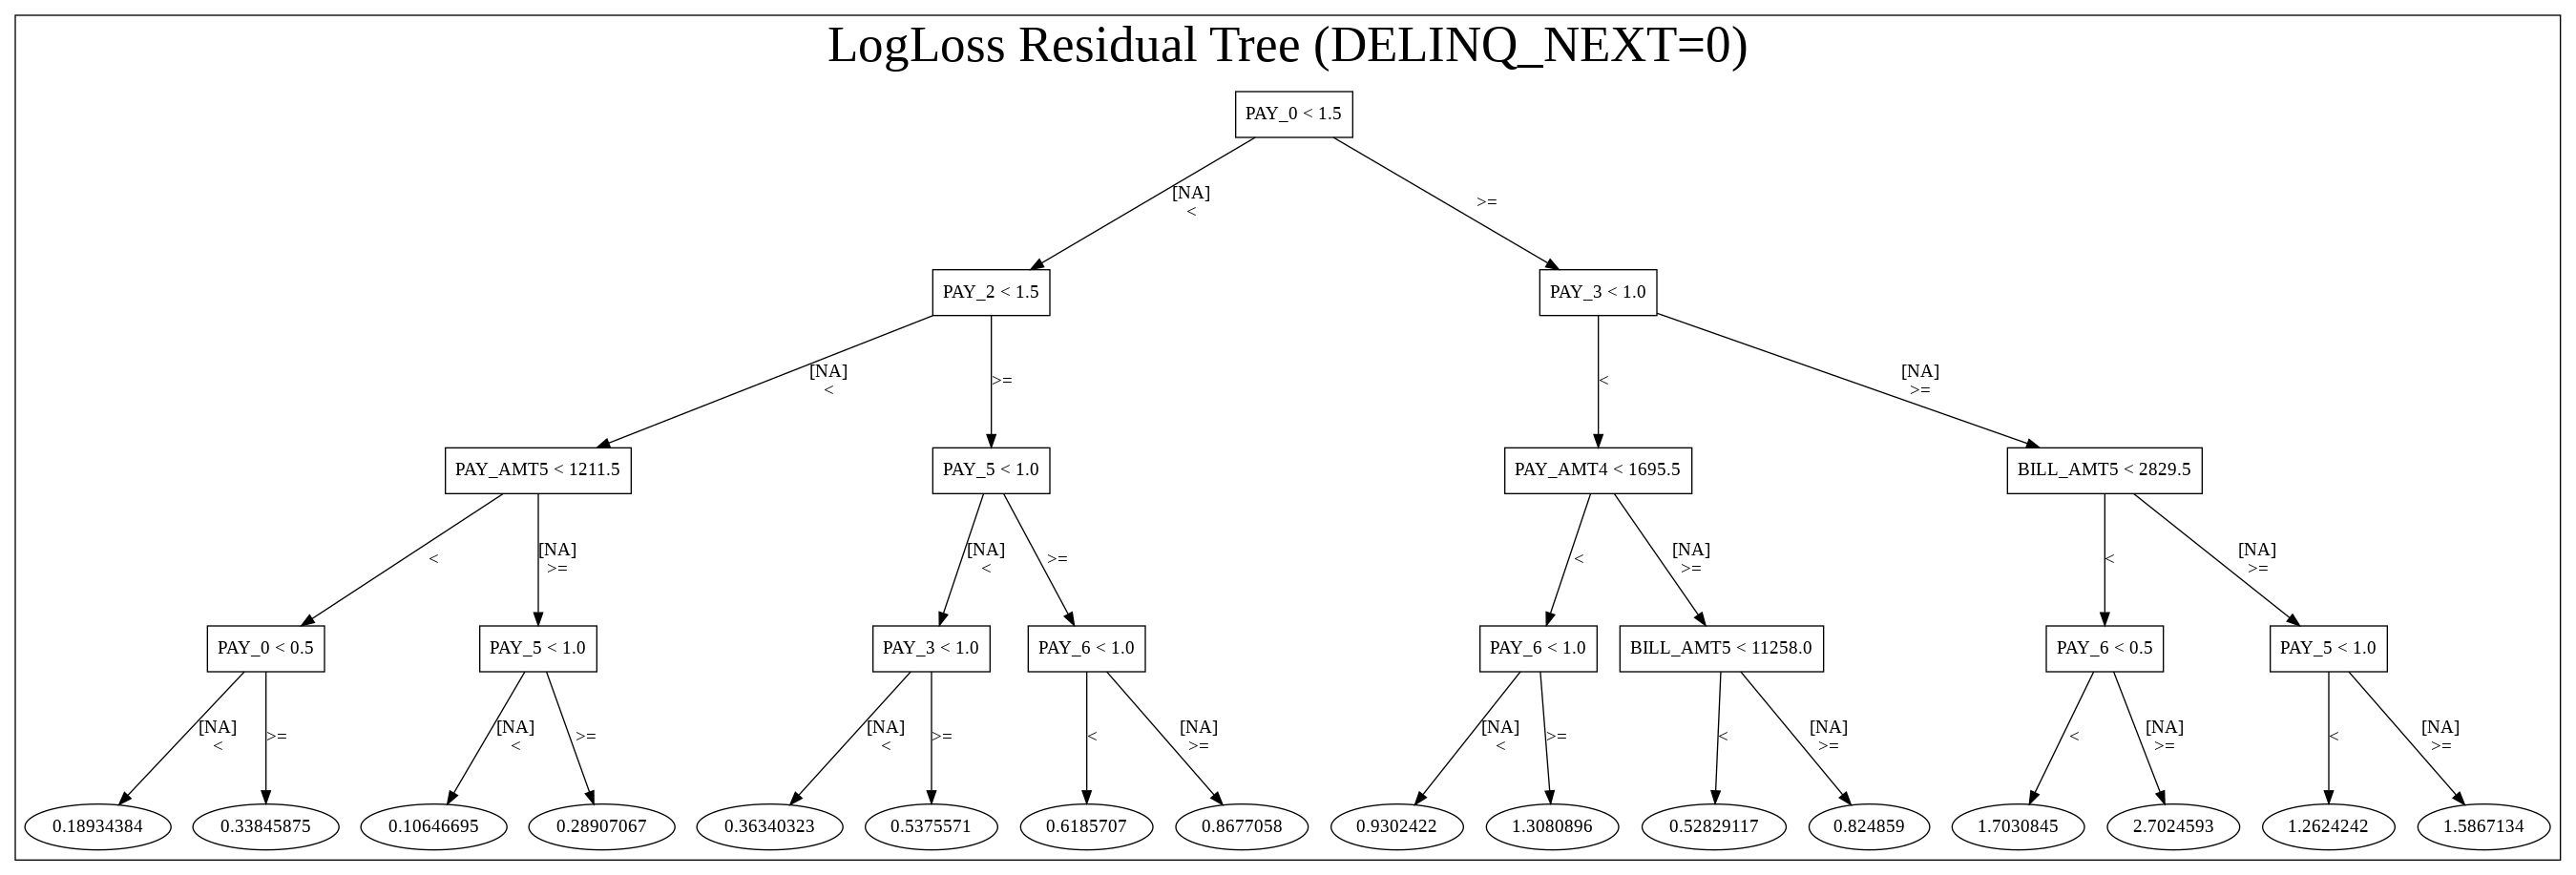

In [34]:
display(Image(('tree0.png')))

#### Decision tree for `DEFAULT_NEXT_MONTH = 1` logloss residuals

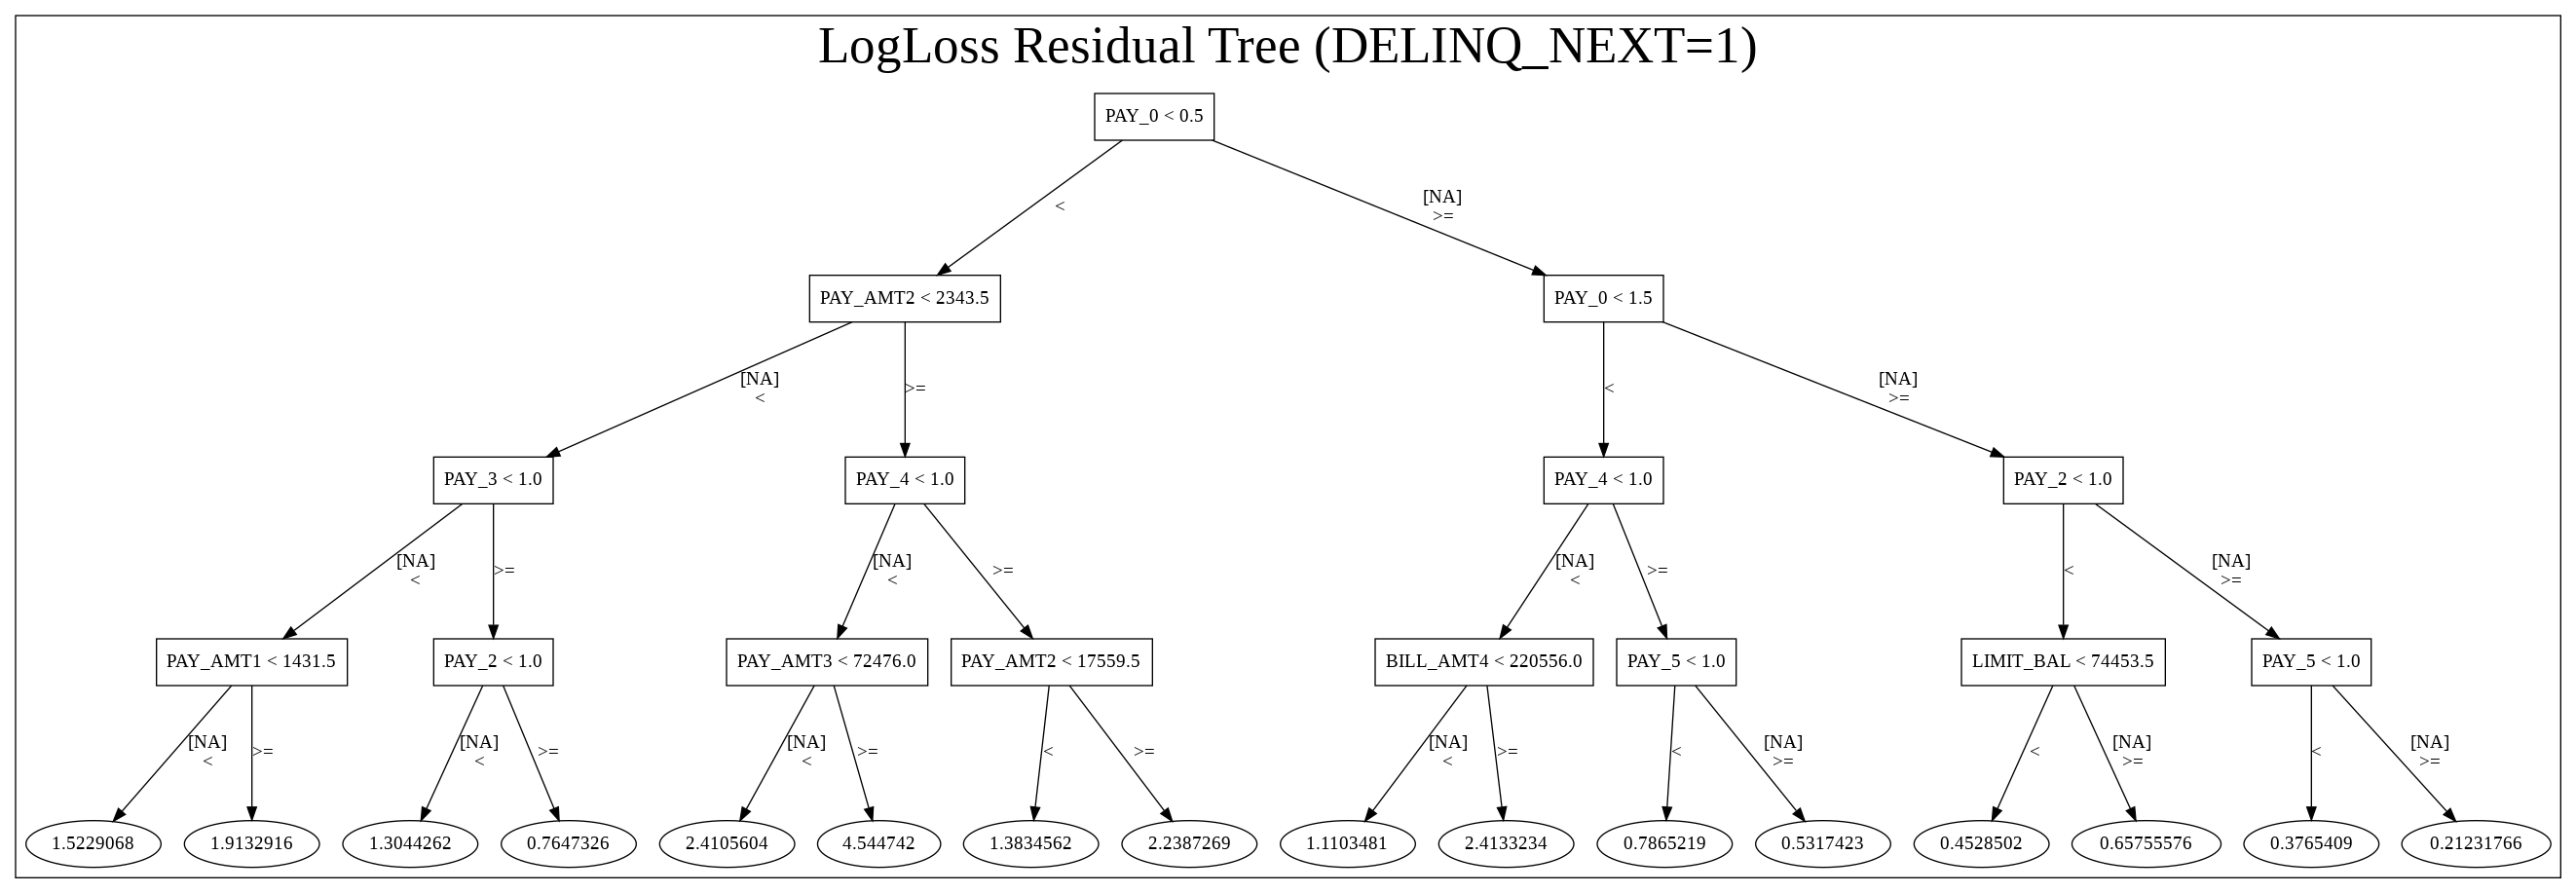

In [35]:
display(Image(('tree1.png')))

Shutdown H2O Cluster

In [36]:
h2o.cluster().shutdown(prompt=True)